In [206]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# For the scatter plot
from sklearn.manifold import TSNE

In [207]:
OUTPUT_DIR = "../AI-CPS/code/learningBase/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [208]:
df = pd.read_csv("../AI-CPS/data/joint_data_collection.csv")
df.head()

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


In [209]:
percentages = df["sarcastic"].value_counts(normalize=True) * 100
print(percentages)


0    74.992789
1    25.007211
Name: sarcastic, dtype: float64


In [210]:
tweets = df["tweet"].astype(str).values
labels = df["sarcastic"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    tweets, labels, test_size=0.2, random_state=42
)


In [211]:
# Maximum number of tokens (vocabulary size)
max_tokens = 1000  
# Maximum length (in tokens) for each tweet
sequence_length = 50

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens, 
    output_mode='int',
    output_sequence_length=sequence_length
)

# "Adapt" the vectorizer to your training tweets (i.e. build the vocabulary)
vectorizer.adapt(X_train)

# Vectorize the text (convert to integer sequences)
X_train_vec = vectorizer(X_train)
X_test_vec = vectorizer(X_test)

print("Vectorized shape:", X_train_vec.shape)
# e.g. (num_samples, 50)


Vectorized shape: (2773, 50)


In [212]:
X_train_vec

<tf.Tensor: shape=(2773, 50), dtype=int64, numpy=
array([[  7, 304, 289, ...,   0,   0,   0],
       [ 33, 353,   1, ...,   0,   0,   0],
       [ 10,  79, 782, ...,   0,   0,   0],
       ...,
       [  3, 846,  28, ...,   0,   0,   0],
       [ 35,  45,  21, ...,   0,   0,   0],
       [315,  29,   7, ...,   0,   0,   0]])>

In [256]:
vocab_size = max_tokens  # same as we used in TextVectorization
embedding_dim = 64

model = Sequential([
    # Input: integer sequences of length `sequence_length`
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length),
    
    # Convolution layer: detects local n-gram features
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    
    # Global max pooling to condense the features into a single vector
    layers.GlobalMaxPooling1D(),
    
    # Dropout to reduce overfitting
    layers.Dropout(0.5),
    
    # Dense layers for classification
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification output
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 64)            64000     
                                                                 
 conv1d (Conv1D)             (None, 46, 64)            20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 16)                1040      
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                      

In [257]:
EPOCHS = 10

history = model.fit(
    X_train_vec, y_train,
    validation_split=0.1,  # some data used for validation
    epochs=EPOCHS,             # start small, can increase if you have bigger data
    batch_size=50,
    verbose=1
)


Epoch 1/10
50/50 [==============================] - 1s 6ms/step - loss: 0.5921 - accuracy: 0.7335 - val_loss: 0.5385 - val_accuracy: 0.7734
Epoch 2/10
50/50 [==============================] - 0s 4ms/step - loss: 0.5567 - accuracy: 0.7575 - val_loss: 0.5380 - val_accuracy: 0.7734
Epoch 3/10
50/50 [==============================] - 0s 4ms/step - loss: 0.5470 - accuracy: 0.7575 - val_loss: 0.5380 - val_accuracy: 0.7734
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 0.5291 - accuracy: 0.7575 - val_loss: 0.5379 - val_accuracy: 0.7734
Epoch 5/10
50/50 [==============================] - 0s 5ms/step - loss: 0.4916 - accuracy: 0.7619 - val_loss: 0.5341 - val_accuracy: 0.7698
Epoch 6/10
50/50 [==============================] - 0s 6ms/step - loss: 0.4288 - accuracy: 0.7992 - val_loss: 0.5621 - val_accuracy: 0.7410
Epoch 7/10
50/50 [==============================] - 0s 5ms/step - loss: 0.3569 - accuracy: 0.8469 - val_loss: 0.6040 - val_accuracy: 0.7626
Epoch 8/10
50/50 [==

In [258]:
test_loss, test_acc = model.evaluate(X_test_vec, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.9210
Test Accuracy: 0.6960


In [259]:
new_tweets = [
    "I love working 80 hours a week with no overtime pay!",
    "I am really enjoying the sunshine today."
]
new_tweets_vec = vectorizer(new_tweets)
predictions = model.predict(new_tweets_vec)

for txt, pred in zip(new_tweets, predictions):
    label = "Sarcastic" if pred >= 0.5 else "Not Sarcastic"
    print(f"{txt} -> {label} (score: {pred[0]:.4f})")


1/1 [==============================] - 0s 29ms/step
I love working 80 hours a week with no overtime pay! -> Sarcastic (score: 0.9101)
I am really enjoying the sunshine today. -> Not Sarcastic (score: 0.0781)


In [263]:
model.save("sarcasm_model.h5")

In [264]:
!mv sarcasm_model.h5 ../AI-CPS/code/ 

In [180]:
history_dict = {
    "epoch": list(range(1, EPOCHS+1)),
    "loss": history.history["loss"],
    "accuracy": history.history["accuracy"],
    "val_loss": history.history["val_loss"],
    "val_accuracy": history.history["val_accuracy"]
}
history_df = pd.DataFrame(history_dict)
history_log_path = os.path.join(OUTPUT_DIR, "training_log.csv")
history_df.to_csv(history_log_path, index=False)

In [181]:
y_pred_probs = model.predict(X_test_vec).ravel()
y_pred = (y_pred_probs >= 0.5).astype(int)
report = classification_report(y_test, y_pred, digits=4)

metrics_file_path = os.path.join(OUTPUT_DIR, "final_metrics.txt")
with open(metrics_file_path, "w") as f:
    f.write(f"Final Test Loss: {test_loss:.4f}\n")
    f.write(f"Final Test Accuracy: {test_acc:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

22/22 [==============================] - 0s 3ms/step


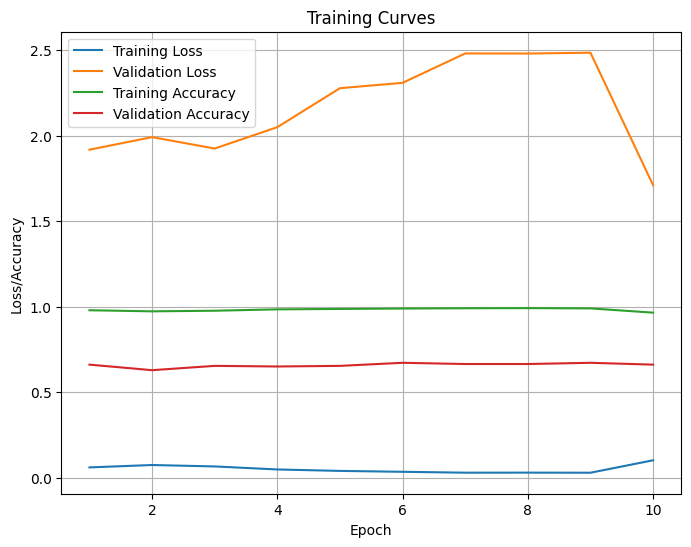

In [182]:
plt.figure(figsize=(8,6))
plt.plot(history_df["epoch"], history_df["loss"], label="Training Loss")
plt.plot(history_df["epoch"], history_df["val_loss"], label="Validation Loss")
plt.plot(history_df["epoch"], history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["epoch"], history_df["val_accuracy"], label="Validation Accuracy")
plt.title("Training Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.grid(True)
training_curve_path = os.path.join(OUTPUT_DIR, "training_curve.png")
plt.savefig(training_curve_path)
plt.show()

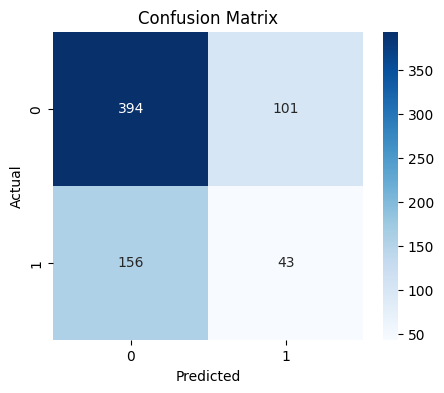

In [183]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
conf_matrix_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.show()